In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic

In [3]:
import getpass
import os
import typing


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [5]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [7]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [8]:
graph_builder.add_edge(START, "chatbot")


In [9]:
graph_builder.add_edge("chatbot", END)

In [10]:
graph = graph_builder.compile()

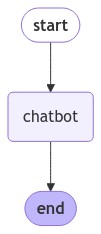

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  what day is today? 


Assistant: I don't actually know what the specific date is today. As an AI assistant without direct access to a calendar, I don't have information about the current date. I can only respond based on the context provided to me in our conversation.
